In [217]:
import matplotlib.pyplot as plt
# from erddapClient import ERDDAP_Griddap
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import cmocean
import datetime

from mpl_toolkits.basemap import Basemap
from matplotlib import colors

In [231]:
file_id = Dataset('/home/jamie/projects/climate/data/chl/chl_1998_2023_l4_month_multi_4k.nc')
ras = file_id.variables["CHL"][:]
lat = file_id.variables["latitude"][:]
lon = file_id.variables["longitude"][:]
time = file_id.variables["time"][:]
file_id.close()

In [232]:
# Convert to timedelta64 with 'D' (days) as the unit
timedelta_vector = (time * np.timedelta64(1, 'D')).astype('timedelta64[ns]')
# Add to base date
base_date = np.datetime64('1900-01-01')
date_vector = base_date + timedelta_vector

In [233]:
# Create a boolean mask for the year 2018
mask_2018 = (date_vector >= np.datetime64('2018-07-01')) & (date_vector < np.datetime64('2018-11-01'))
dates_2018 = date_vector[mask_2018]
ras_2018 = ras[mask_2018]
ras_2018 = np.clip(ras_2018, 0.05, 0.25)

In [234]:
dates_2018 = dates_2018.astype('M')
date_str_vector = np.char.replace(dates_2018.astype(str), 'T00:00:00', '')  # Remove the time part
date_str_vector = np.char.replace(date_str_vector, '.000000000', '')  # Remove the time part

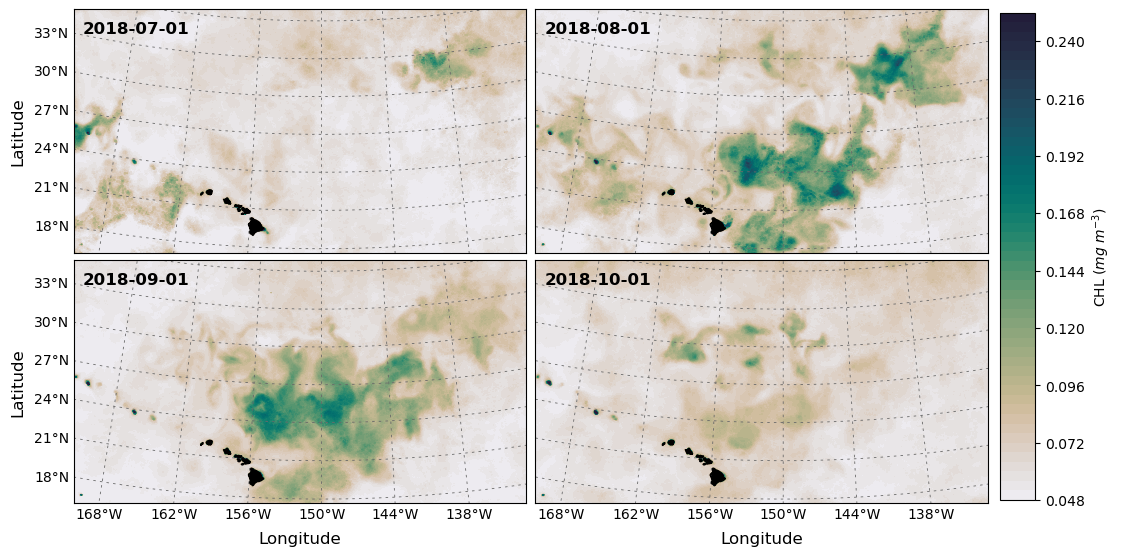

In [236]:
# Calculate the bounds of the data
lat_bounds = [lat.min(), lat.max()]
lon_bounds = [lon.min(), lon.max()]
# Create latitude and longitude grids for contourf
lats = np.linspace(lat_bounds[0], lat_bounds[1], ras_2018.shape[1])
lons = np.linspace(lon_bounds[0], lon_bounds[1], ras_2018.shape[2])
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Set up a 2x2 grid for subplots
# fig = plt.subplots(2, 2, figsize=(15, 10))
# fig = plt.figure(figsize=(9.9, 5.5))
fig = plt.figure(figsize=(11.8, 6.5))
axs = [fig.add_subplot(2,2,i+1) for i in range(4)]

# Loop through the subplots and plot each array
for i, ax in enumerate(axs): # .flat):
    m = Basemap(projection='lcc', resolution='h', 
                llcrnrlat=16, urcrnrlat=35.5, 
                llcrnrlon=-170, urcrnrlon=-130,
                lat_0 = 30, lon_0 = -150,
                width=5.1E6, height=5E6,
                ax=ax)
    x, y = m(lon_grid, lat_grid)
    tmp = xr.DataArray(ras_2018[i,:,:], 
                   coords={'x': lat, 'y':lon}, 
                   dims=["x", "y"])

    # cp = m.contourf(x, y, ras_2018[i], cmap = cmocean.cm.rain, levels=100, extend='both')
    cp = axs[i].contourf(x, y, tmp, levels = 50, cmap = cmocean.cm.rain)
    # ax.set_title(dates_2018[i], loc='left', pad=-20)
    ax.text(0.02, 0.95, date_str_vector[i], transform=ax.transAxes,
        fontsize=12, fontweight='bold', va='top', ha='left')
    
    labels = [0,0,0,0]
    if i in [0,2]:
        labels=[1,0,0,0]
        axs[i].set_ylabel("Latitude", labelpad=35, size =12)
    parallels = m.drawparallels(np.arange(18, 40, 3), labels=labels, textcolor = 'black', color = "dimgrey", fontsize=10, dashes=(3, 5), linewidth = 0.6)
    labels = [0,0,0,0]
    if i in [2,3]:
        labels=[0,0,0,1]
        axs[i].set_xlabel("Longitude", labelpad=20, size =12)
    meridians =  m.drawmeridians(np.arange(-168, -135, 6), labels=labels, textcolor = 'black', color = "dimgrey", fontsize=10, dashes=(3, 5),linewidth = 0.6)
    # Draw coastlines and countries
    m.drawcoastlines(color='black')
    m.fillcontinents(color = 'black')
    # ax.set_title(f'Array {i+1}')
# reduce padding on subplots. 
cbar_ax = fig.add_axes([0.91, 0.12, 0.03, 0.75])  # [left, bottom, width, height]
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label('CHL ($mg$ $m^{-3}$)')
plt.subplots_adjust(wspace=0.02, hspace=0.001) 
plt.savefig('../../figures/chl_mon_2018_20240815.png', bbox_inches='tight', dpi = 300)
plt.savefig('../../figures/chl_mon_2018_20240815.pdf', bbox_inches='tight')
plt.show()
